# Using topic modeling to extract topics from documents

Sometimes you have a nice big set of documents, and all you wish for is to know what's hiding inside. But without reading them, of course! Two approaches to try to lazily get some information from your texts are **topic modeling** and **clustering**.

<p class="reading-options">
  <a class="btn" href="/text-analysis/introduction-to-topic-modeling">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/text-analysis/notebooks/Introduction to topic modeling.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/text-analysis/notebooks/Introduction to topic modeling.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **recipes.csv:** recipes - a list of recipes (but only with ingredient names)
* **state-of-the-union.csv:** State of the Union addresses - each presidential address from 1970 to 2012


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv -P data

## How computers read

I'm going to tell you a big secret: **computers are really really really bad at reading documents and figuring out what they're about.** Text is for _people_ to read, people with a collective knowledge of The World At Large and a history of reading things and all kinds of other tricky secret little things we don't think about that help us understand what a piece of text means.

When dealing with understanding content, computers are good for _very specific situations_ to do _very specific things_. Or alternatively, to do a not-that-great job when you aren't going to be terribly picky about the results.

Do I sound a little biased? Oh, but aren't we all. It isn't going to stop us from talking about it, though!

Before we start, **let's make some assumptions:**

* When you're dealing with documents, each document is (typically) about something.
* You know each document is about by looking at the words in the document.
* Documents with similar words are probably about similar things. 

We have two major options available to us: **topic modeling** and **clustering**. There's a lot of NLP nuance going on between the two, but we're going to keep it simple:

**Topic modeling** is if each document can be about **multiple topics**. There might be 100 different topics, and a document might be 30% about one topic, 20% about another, and then 50% spread out between the others.

**Clustering** is if each document should only fit into **one topic**. It's an all-or-nothing approach.

The most important part of _all of this_ is the fact that **the computer figures out these topics by itself**. You don't tell it what to do! If you're teaching the algorithm what different specific topics look like, that's **classification.** In this case we're just saying "hey computer, please figure this out!"

Let's get started.

In [316]:
import pandas as pd
import matplotlib.pyplot as plt

# These styles look nicer than default pandas
plt.style.use('ggplot')

# We'll be able to see more text at once
pd.set_option("display.max_colwidth", 100)

## Attempt one: Recipes

### Our dataset

We're going to start with analyzing **about 36,000 recipes**. Food is interesting because you can split it so many ways: by courses, or by baked goods vs meat vs vegetables vs others, by national cuisine...

In [317]:
recipes = pd.read_csv("data/recipes.csv")
recipes.head()

,cuisine,id,ingredient_list
0,greek,10259,"romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo..."
1,southern_us,25693,"plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, ye..."
2,filipino,20130,"eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powde..."
3,indian,22213,"water, vegetable oil, wheat, salt"
4,indian,13162,"black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lem..."


In order to analyze the text, we'll need to count the words in each recipe. To do that we're going to use a **stemmed TF-IDF vectorizer** from scikit-learn.

* **Stemming** will allow us to combine words like `tomato` and `tomatoes`
* Using **TF-IDF** will allow us to devalue common ingredients like salt and water

I'm using the code from [the reference section](https://investigate.ai/reference/vectorizing/#stem-and-vectorize), just adjusted from a `CountVectorizer` to a `TfidfVectorizer`, and set it so ingredients have to appear in at least **fifty recipes**.

In [318]:
from sklearn.feature_extraction.text import TfidfVectorizer
import Stemmer

# English stemmer from pyStemmer
stemmer = Stemmer.Stemmer('en')

analyzer = TfidfVectorizer().build_analyzer()

# Override TfidfVectorizer
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords(analyzer(doc))

In [319]:
vectorizer = StemmedTfidfVectorizer(min_df=50)
matrix = vectorizer.fit_transform(recipes.ingredient_list)

words_df = pd.DataFrame(matrix.toarray(),
                        columns=vectorizer.get_feature_names())
words_df.head()

,activ,adobo,agav,alfredo,all,allspic,almond,amchur,anaheim,ancho,...,wrapper,yam,yeast,yellow,yoghurt,yogurt,yolk,yukon,zest,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.278745,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.276000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.210575,0.0,0.0,0.0,0.0


Looks like we have 752 ingredients! Yes, there are some numbers in there and probably other things we aren't interested in, but let's stick with it for now.

## Topic modeling

There are multiple techniques for topic modeling, but in the end they do the same thing: **you get a list of topics, and a list of words associated with each topic.**

Let's tell it to break them down into **five topics.**

In [320]:
from sklearn.decomposition import NMF

model = NMF(n_components=5)
model.fit(matrix)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

Why five topics? **Because we have to tell it _something_.** Our job is to decide the number of topics, and it's the computer's job to find the topics. We'll talk about how to pick the "right" number later, but for now: it's magic.

Fitting the model allowed it to "learn" what the ingredients are and how they're organized, we just need to find out what's inside. Let's ask for the **top ten terms in each group.**

In [321]:
n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model.components_):
    top_features = [feature_names[i] for i in topic.argsort()][::-1][:n_words]
    top_n = ' '.join(top_features)
    topic_list.append(f"topic_{'_'.join(top_features[:3])}") 

    print(f"Topic {topic_idx}: {top_n}")

Topic 0: oliv pepper fresh oil dri garlic salt parsley red tomato
Topic 1: flour egg sugar purpos all butter bake milk larg powder
Topic 2: sauc soy sesam rice oil ginger sugar chicken vinegar garlic
Topic 3: ground chili cilantro cumin powder lime onion pepper chop fresh
Topic 4: chees shred cream parmesan cheddar grate tortilla mozzarella sour chicken


In [322]:
print(topic_list)

['topic_oliv_pepper_fresh', 'topic_flour_egg_sugar', 'topic_sauc_soy_sesam', 'topic_ground_chili_cilantro', 'topic_chees_shred_cream']


Those actually seem like _pretty good topics_. Italian-ish, then baking, then Chinese, maybe Latin American or Indian food, and then dairy. What if we did it with **fifteen topics** instead?

In [323]:
model = NMF(n_components=15)
model.fit(matrix)

n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")

Topic 0: pepper bell red green onion celeri flake black tomato crush
Topic 1: flour purpos all bake powder butter soda buttermilk salt egg
Topic 2: sauc soy sesam oil ginger rice sugar garlic scallion starch
Topic 3: tortilla cream shred chees sour cheddar salsa corn bean jack
Topic 4: chees parmesan grate mozzarella pasta ricotta basil italian fresh spinach
Topic 5: lime cilantro fresh chop juic jalapeno chile avocado chili fish
Topic 6: chicken breast boneless skinless broth halv sodium low fat thigh
Topic 7: ground black pepper cumin cinnamon salt beef cayenn kosher paprika
Topic 8: chili seed powder cumin coriand masala garam curri ginger coconut
Topic 9: sugar egg vanilla milk extract larg cream butter yolk unsalt
Topic 10: oliv extra virgin oil clove garlic fresh salt tomato parsley
Topic 11: white wine vinegar rice shallot red salt grain mustard sugar
Topic 12: dri oregano tomato thyme parsley garlic bay basil leaf onion
Topic 13: lemon juic fresh orang zest parsley grate mint p

This is where we start to see **the big difference between categories and topics**. The grouping with five groups seemed very much like cuisines - Italian, Chinese, etc. But now that we're breaking it down further, the groups have changed a bit.

They're now **more like classes of ingredients.** Baking gets a category - `chicken breast boneless skinless` and so do generic Mediterranean ingredients - `oliv extra virgin oil clove garlic fresh salt`. The algorithm got a little confused about black pepper vs. hot pepper flakes vs green/yellow bell peppers when it created `pepper bell red green onion celeri flake black`, but we understand what it's going for.

Remember, the important thing about topic modeling is that every row in our dataset is a **combinations of topics**. It might be a little bit about one thing, a little bit less about another, etc etc. Let's take a look at how that works.

In [324]:
# If we don't want 'real' names for the topics, we can run this line
# topic_list = [f"topic_{i}" for i in range(model.n_components_)]

# Convert our counts into numbers
amounts = model.transform(matrix) * 100

# Set it up as a dataframe
topics = pd.DataFrame(amounts, columns=topic_list)
topics.head(2)

,topic_pepper_bell_red,topic_flour_purpos_all,topic_sauc_soy_sesam,topic_tortilla_cream_shred,topic_chees_parmesan_grate,topic_lime_cilantro_fresh,topic_chicken_breast_boneless,topic_ground_black_pepper,topic_chili_seed_powder,topic_sugar_egg_vanilla,topic_oliv_extra_virgin,topic_white_wine_vinegar,topic_dri_oregano_tomato,topic_lemon_juic_fresh,topic_water_yeast_warm
0,1.438751,0.000000,0.000000,2.671147,1.613176,0.2249,0.0,0.507867,0.0000,0.00000,2.561140,0.0,0.472827,0.0,0.0000
1,2.447803,3.044097,0.176603,1.411024,0.000000,0.0000,0.0,5.717447,0.4958,1.59881,0.548627,0.0,1.592754,0.0,0.2495


Our first recipe is primary `topic_3` with a rating of 2.44, but it's also a bit topic 0 and topic 8 with scores of 1.5 and 1.36.

Our second recipe is a bit bolder - it scores a whopping 5.7 in `topic_7`, with 0, 8 and 14 coming up in the 2.5-3 range.

Let's combine this topics dataframe with our **original dataframe** so we can see it all in one place.

In [325]:
merged = recipes.merge(topics, right_index=True, left_index=True)
merged.head(2)

,cuisine,id,ingredient_list,topic_pepper_bell_red,topic_flour_purpos_all,topic_sauc_soy_sesam,topic_tortilla_cream_shred,topic_chees_parmesan_grate,topic_lime_cilantro_fresh,topic_chicken_breast_boneless,topic_ground_black_pepper,topic_chili_seed_powder,topic_sugar_egg_vanilla,topic_oliv_extra_virgin,topic_white_wine_vinegar,topic_dri_oregano_tomato,topic_lemon_juic_fresh,topic_water_yeast_warm
0,greek,10259,"romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo...",1.438751,0.000000,0.000000,2.671147,1.613176,0.2249,0.0,0.507867,0.0000,0.00000,2.561140,0.0,0.472827,0.0,0.0000
1,southern_us,25693,"plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, ye...",2.447803,3.044097,0.176603,1.411024,0.000000,0.0000,0.0,5.717447,0.4958,1.59881,0.548627,0.0,1.592754,0.0,0.2495


Now we can do things like...

* Uncover possible topics discussed in the dataset
* See how many documents cover each topic
* Find the top documents in each topic

And **graph it!** Let's see what our distribution of topics looks like.

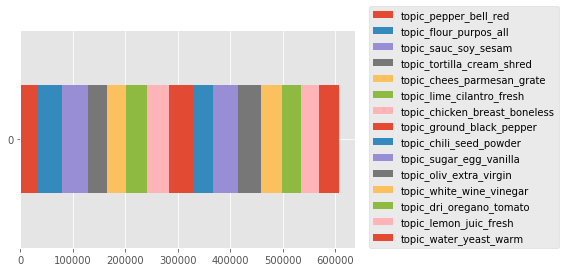

In [340]:
ax = merged[topic_list].sum().to_frame().T.plot(kind='barh', stacked=True)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

Suspiciously even, but that's an investigation for another day. Let's try a different dataset that splits a little differently.

## Attempt two: State of the Union addresses

One of the fun things to do with topic modeling is see how **things change over time.** For this example, we're going to reproduce an assignment from [Jonathan Stray's Computational Journalism course](http://www.compjournalism.com/?p=208).

At the beginning of each year, the President of the United States traditionally addresses Congress in a speech called the State of the Union. It's a good way to judge what's important in the country at the time, because the speech is sure to be used as a platform to address the legislative agenda for the year. Let's see if topic modeling can help illustrate how it's **changed over time.**

### Our data

We have a simple CSV of State of the Union addresses, nothing too crazy.

In [357]:
speeches = pd.read_csv("data/state-of-the-union.csv")
speeches.sample(5)

,year,content
60,1849,"\nState of the Union Address\nZachary Taylor\nDecember 4, 1849\n\nFellow-Citizens of the Senate ..."
94,1883,"\nState of the Union Address\nChester A. Arthur\nDecember 4, 1883\n\nTo the Congress of the Unit..."
63,1852,"\nState of the Union Address\nMillard Fillmore\nDecember 6, 1852\n\nFellow-Citizens of the Senat..."
148,1938,"\nState of the Union Address\nFranklin D. Roosevelt\nJanuary 3, 1938\n\nMr. President, Mr. Speak..."
156,1946,"\nState of the Union Address\nHarry S. Truman\nJanuary 21, 1946\n\nTo the Congress of the United..."


It's not too many, only a little over 226. Because it's a smaller dataset, we're able to do more computationally intensive forms of topic modeling (LDA, for example) without sitting around getting bored.

In [358]:
speeches.shape

(226, 2)

To help the analysis out a bit, we're going to clean the text. Only a little bit, though - we'll just remove anything that isn't a word.

In [359]:
# Remove non-word characters, so numbers and ___ etc
speeches.content = speeches.content.str.replace("[^A-Za-z ]", " ")
speeches.head()

,year,content
0,1790,George WashingtonJanuary Fellow Citizens of the Senate and House of Representatives I emb...
1,1790,State of the Union AddressGeorge WashingtonDecember Fellow Citizens of the Senate and Hou...
2,1791,State of the Union AddressGeorge WashingtonOctober Fellow Citizens of the Senate and Hou...
3,1792,State of the Union AddressGeorge WashingtonNovember Fellow Citizens of the Senate and Hou...
4,1793,State of the Union AddressGeorge WashingtonDecember Fellow Citizens of the Senate and Hou...


### Vectorize

We're going to use the same TF-IDF vectorizer we used up above, which stems in addition to just vectorizing. We'll reproduce the code down here for completeness's sake (and easy cut-and-paste).

In [360]:
from sklearn.feature_extraction.text import TfidfVectorizer
import Stemmer

# English stemmer from pyStemmer
stemmer = Stemmer.Stemmer('en')

analyzer = TfidfVectorizer().build_analyzer()

# Override TfidfVectorizer
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords(analyzer(doc))

With our first pass we'll **vectorize everything**, no limits!

In [361]:
vectorizer = StemmedTfidfVectorizer(stop_words='english')
matrix = vectorizer.fit_transform(speeches.content)

words_df = pd.DataFrame(matrix.toarray(),
                        columns=vectorizer.get_feature_names())
words_df.head()

,aaa,aana,aaron,abail,abal,abalanc,abandon,abandonedbi,abandonednow,abandonedtheir,...,zimbabwean,zinc,zionchurch,zollverein,zone,zoneof,zonesin,zoolog,zoom,zuloaga
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Running NME/NMF topic modeling

Now we'll leap into topic modeling. We'll look at fifteen topics, since we're covering a long span of time where lots of different things may have happened.

In [362]:
model = NMF(n_components=15)
model.fit(matrix)

n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")

Topic 0: state govern mexico unit congress constitut territori power countri act
Topic 1: program year nation billion new feder congress help american goal
Topic 2: america tonight year ve american job work let peopl help
Topic 3: war enemi fight victori nation japanes hitler american forc men
Topic 4: law nation govern state work corpor men great man peopl
Topic 5: state unit nation public govern congress year great commerc million
Topic 6: terrorist iraq america iraqi terror tonight american al help regim
Topic 7: soviet world nation free defens communist peac econom militari freedom
Topic 8: govern state bank public subject countri duti peopl treasuri general
Topic 9: year state govern unit report law congress cent silver increas
Topic 10: govern state unit treati countri congress american relat convent spain
Topic 11: nation world govern peopl democraci today problem state peac congress
Topic 12: gentlemen state unit nation public law measur indian object repres
Topic 13: shall mat

Let's be honest with ourselves: **we expected something a bit better.** So many of these words are so _common_ that it doesn't do much to convince me these are meaningful concepts.

### Adjusting our min and max document frequency

One way to cut those overly broad topics from our topic model is to **remove them from the vectorizer.** Instead of accepting _all_ words, we can set minimum or maximum limits.

Let's only accept words used **in at least 5 speeches**, but also **don't appear in more than half of the speeches**.

In [363]:
vectorizer = StemmedTfidfVectorizer(stop_words='english', min_df=5, max_df=0.5)
matrix = vectorizer.fit_transform(speeches.content)

words_df = pd.DataFrame(matrix.toarray(),
                        columns=vectorizer.get_feature_names())
words_df.head()

,abal,abalanc,abandon,abat,abdic,abett,abey,abhorr,abid,abil,...,yourfavor,youth,youto,youwil,yukon,zeal,zealand,zealous,zero,zone
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.082383,0.0,0.00000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.061166,0.0,0.0
3,0.0,0.0,0.0,0.071243,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.04508,0.0,0.062934,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0


And now we'll **check the topic model.**

In [364]:
model = NMF(n_components=15)
model.fit(matrix)

n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")

Topic 0: island cuba arbitr june spain pension award confer consular commission
Topic 1: program billion today goal budget achiev area level farm percent
Topic 2: ve job tonight budget cut ll school spend don deficit
Topic 3: spain coloni franc articl intercours tribe minist port navig commenc
Topic 4: terrorist iraq iraqi terror tonight al regim afghanistan qaeda fight
Topic 5: fight enemi japanes today democraci victori tank plane task attack
Topic 6: mexico texa mexican oregon california annex minist articl steamer loan
Topic 7: method relief cent veteran board farmer farm tariff depress committe
Topic 8: silver gold currenc note circul coinag cent bond coin speci
Topic 9: soviet communist atom threat aggress ve missil korea weapon ii
Topic 10: militia british enemi council tribe whilst decre port regular neutral
Topic 11: gentlemen commission amiti satisfact articl burthen militia prospect majesti hostil
Topic 12: corpor interst forest island philippin railroad deal class supervis 

That's looking a little more interesting! Lots of references to wars and political conflict, along with slavery and monetary policy.

## Visualizing the outcome

We can get a better handle on what our data looks like through a little visualization. We'll start by loading up the **topic popularity dataframe**. Remember that each row is one of our speeches.

In [365]:
# Convert our counts into numbers
amounts = model.transform(matrix) * 100

# Set it up as a dataframe
topics = pd.DataFrame(amounts, columns=topic_list)
topics.head(2)

,topic_island_cuba_arbitr,topic_program_billion_today,topic_ve_job_tonight,topic_spain_coloni_franc,topic_terrorist_iraq_iraqi,topic_fight_enemi_japanes,topic_mexico_texa_mexican,topic_method_relief_cent,topic_silver_gold_currenc,topic_soviet_communist_atom,topic_militia_british_enemi,topic_gentlemen_commission_amiti,topic_corpor_interst_forest,topic_kansa_slave_slaveri,topic_vietnam_tonight_billion
0,0.0,0.0,0.0,2.404538,0.0,0.116872,0.0,0.0,0.761927,0.0,0.000000,33.359101,0.0,0.0,0.138286
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,13.178591,25.444151,0.0,0.0,1.364718


The first row is our first speech, the second row is our second speech, and so on.

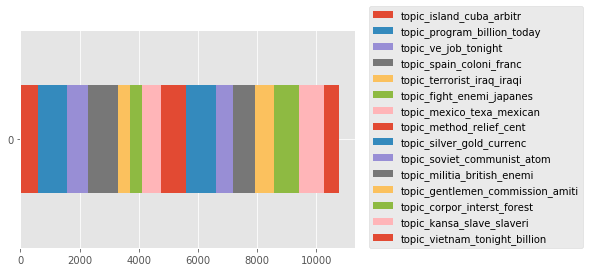

In [366]:
ax = topics.sum().to_frame().T.plot(kind='barh', stacked=True)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

Again, pretty even! A few are larger or smaller, but overall the topics seem pretty evenly distributed.

Looking at things over all time doesn't mean much, though, we're interseted in **change over time**.

The hip way to do this is with a **streamgraph**, which is a stacked area graph that centers on the vertical axis. Usually you'd have to merge the two dataframes in order to graph, but we can sneakily get around it since we aren't plotting with pandas (plotting streamgraphs requires directly talking to matplotlib).

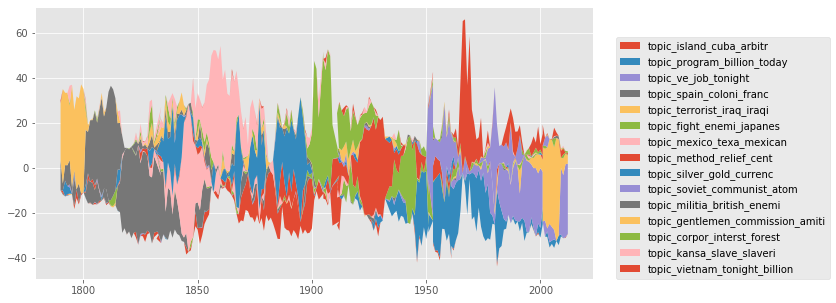

In [367]:
x_axis = speeches.year
y_axis = topics

fig, ax = plt.subplots(figsize=(10,5))

# Plot a stackplot - https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/stackplot_demo.html
ax.stackplot(x_axis, y_axis.T, baseline='wiggle', labels=y_axis.columns)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

I know that "Presidents talk about current news topics" is probably not the most exciting things you've ever seen, but you can watch things rise and fall easily enough.

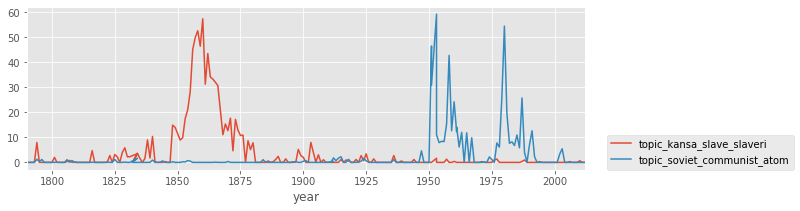

In [368]:
merged = topics.join(speeches)

ax = merged.plot(x='year', y=['topic_kansa_slave_slaveri', 'topic_soviet_communist_atom'], figsize=(10,3))
ax.legend(loc=(1.04,0))

## So what do you do with this?

Good question. TODO.

## Review

In this section we looked at **topic modeling**, a technique of extracting topics out of text datasets. Unlike clustering, where each document is assigned one category, in topic modeling **each document is considered blend of different topics.**

You don't need to "teach" a topic model anything about your dataset, you just let it loose and it comes back with what terms represent each topic. The only thing you need to give it is the **number of topics to find**.

The way you preprocess the text is very important to a topic model. We found that common words ended up appearing in many topics unless we used `max_df=` in our vectorizer to filter out high-frequency words.

There are many different algorithms to use for topic modeling, but we're saving that for a later section.

## Discussion topics

TODO